# Figures 2 and 3
Figure panels for UCSF-Biohub COVID Tissue Atlas. <br>
Nov 2021 <br>
Authors: Alejandro Granados, Ann Chen <br>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import sys
import matplotlib as mpl
import os 
#add path where utils.py will be called
sys.path.append('/mnt/ibm_lg/covid_tissue_atlas/CovidTissueAtlas/cta_utils/')
import utils
import viz_utils
from matplotlib import cm



# Notebook parameters 
this_sample ='heart'
FIG_DIR = viz_utils.setup_fig_params(this_sample )

# Location of organ h5ad 
MASTER_DIR = '/mnt/ibm_lg/covid_tissue_atlas/data/tissue_objects/all_tissues/portal/'
sc.settings.verbosity = 3            
sc.set_figure_params(dpi=150)
sc.settings.figdir = FIG_DIR




package versions:
matplotlib 3.3.1
scanpy 1.7.2


/data/alejandro/miniconda3/envs/scanpy/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


Make UMAPs and save pdf 

In [2]:
adata = sc.read_h5ad(MASTER_DIR + 'CTA_' + this_sample + '.h5ad')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


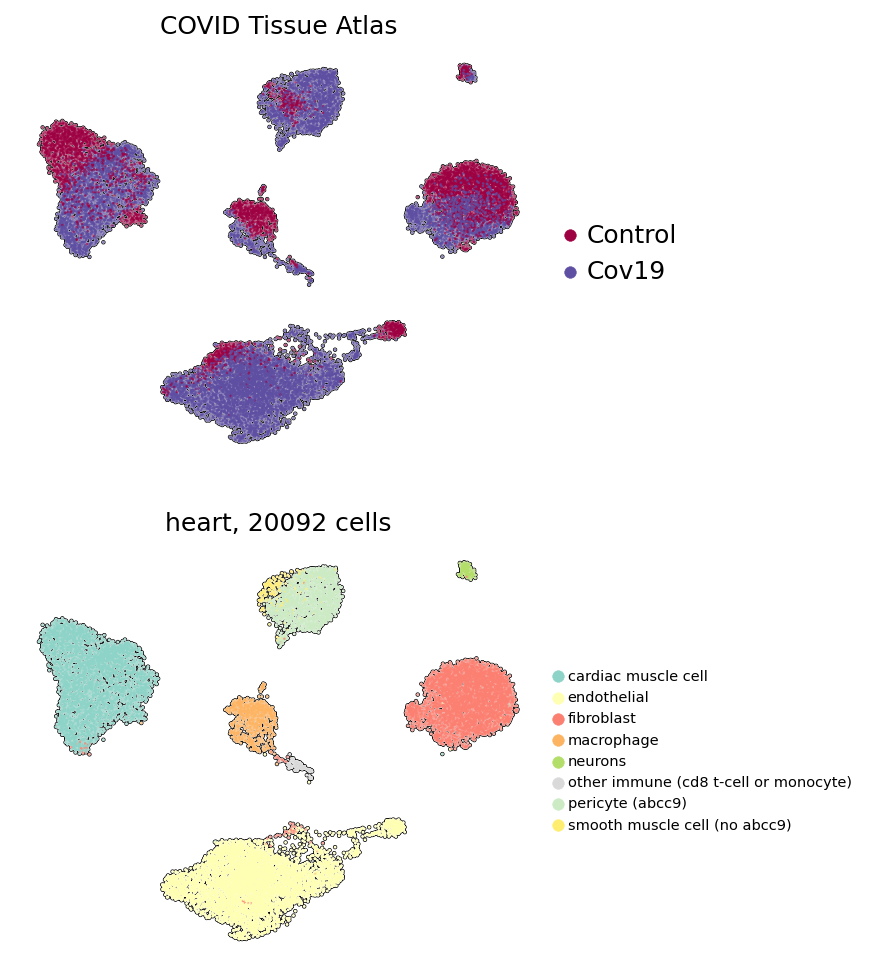

In [3]:
from matplotlib.pyplot import rc_context
viz_utils.set_plotting_style() 
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(4.5,8))

n_cells  = adata.X.shape[0]

sc.pl.umap(adata, color='disease_status', add_outline=True, legend_loc='right margin',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='COVID Tissue Atlas', palette='Spectral',
               ax=ax[0], show = False)
    
sc.pl.umap(adata, color='cell_type_annotation', add_outline=True,
               legend_fontsize=7, legend_fontoutline=1,frameon=False,
               title= f'{this_sample}, {n_cells} cells', palette='Set3', 
               ax = ax[1])

fig.savefig(FIG_DIR + this_sample + '_umaps.svg', dpi=400, bbox_inches='tight', transparent=True)
plt.show() 

## Cell type populations

In [8]:
cell_type_label = 'short_cell_type'
stacked_df = adata.obs[['disease_status', cell_type_label]]
cluster_disease = stacked_df.pivot_table(index=cell_type_label, columns=['disease_status'], aggfunc='size')
cluster_disease_pct = cluster_disease.div(cluster_disease.sum(axis=0), axis=1) * 100
organs_covid = cluster_disease_pct.sort_values(by ="Cov19", ascending = False )


donor_col = 'sampleID'
# set plot style: grey grid in the background:
sns.set(style="whitegrid")

# set the figure size
df = adata.obs
# top bar -> sum all values(smoker=No and smoker=Yes) to find y position of the bars
stacked_df = adata.obs[[donor_col, cell_type_label]]
cluster_disease = stacked_df.pivot_table(index = donor_col, columns= cell_type_label, aggfunc='size')
sorted_donors = cluster_disease.sum(axis = 1).sort_values()

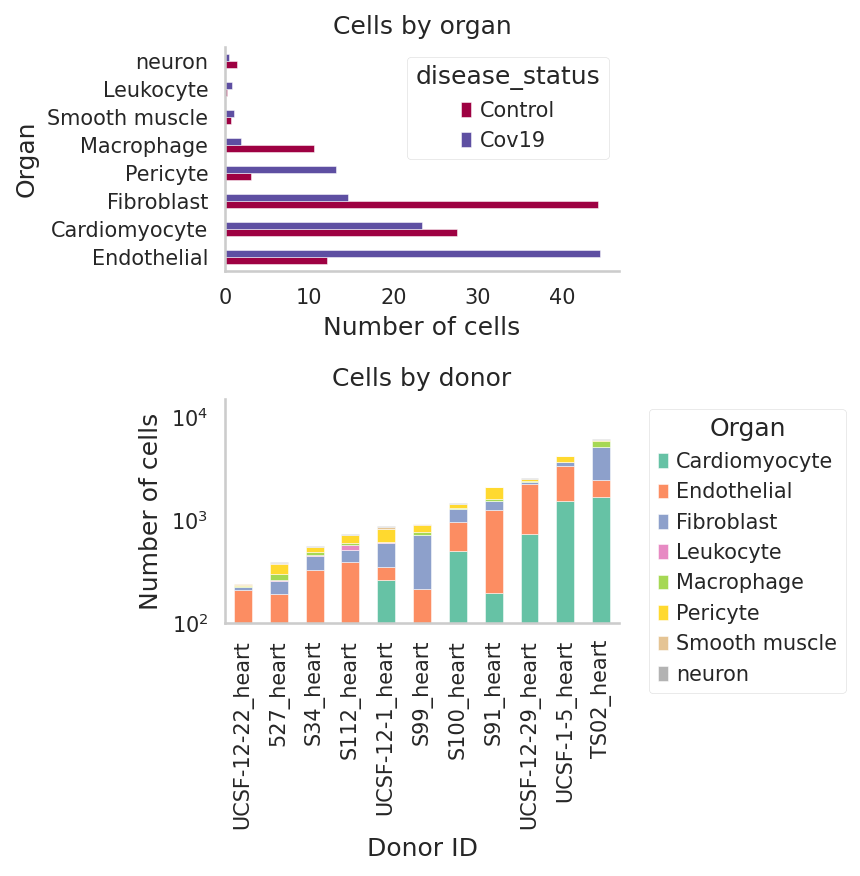

In [9]:
viz_utils.set_plotting_style() 

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,6), dpi = 150)

# Panel A 
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)
#ax[0].set_xscale('log')

organs_covid.plot(kind='barh', stacked=False, 
                     colormap=cmap,
                     grid = False,ax = ax[0])

# Panel B 
ax[1].set_yscale('log')
cmap = cm.get_cmap('Set2') # Colour map (there are many others)

cluster_disease.loc[sorted_donors.index].plot(kind='bar', 
                                              stacked=True, 
                                              ax = ax[1],
                                              cmap = cmap, 
                                              grid =False, ylim = (100,20000) )
ax[1].legend(bbox_to_anchor=(1.05, 1), title = 'Organ')
# plt.legend(loc='upper left', 
#             title='Organ'
#            )
plt.ylim((100,15000))

titles = ['Cells by organ', 'Cells by donor']
xlabels = ['Number of cells','Donor ID']
ylabels = ['Organ','Number of cells']

for i,axes in enumerate( ax.flat):
     viz_utils.stylize_axes(axes, titles[i], xlabels[i], ylabels[i])
        
plt.tight_layout()

fig.savefig(FIG_DIR + 'barplots_celltype.pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show() 
 

## Expression of COVID genes 

Storing dendrogram info using `.uns['dendrogram_short_cell_type']`
categories: Cardiomyocyte, Endothelial, Fibroblast, etc.
var_group_labels: Entry genes, Entry receptors, Entry proteases


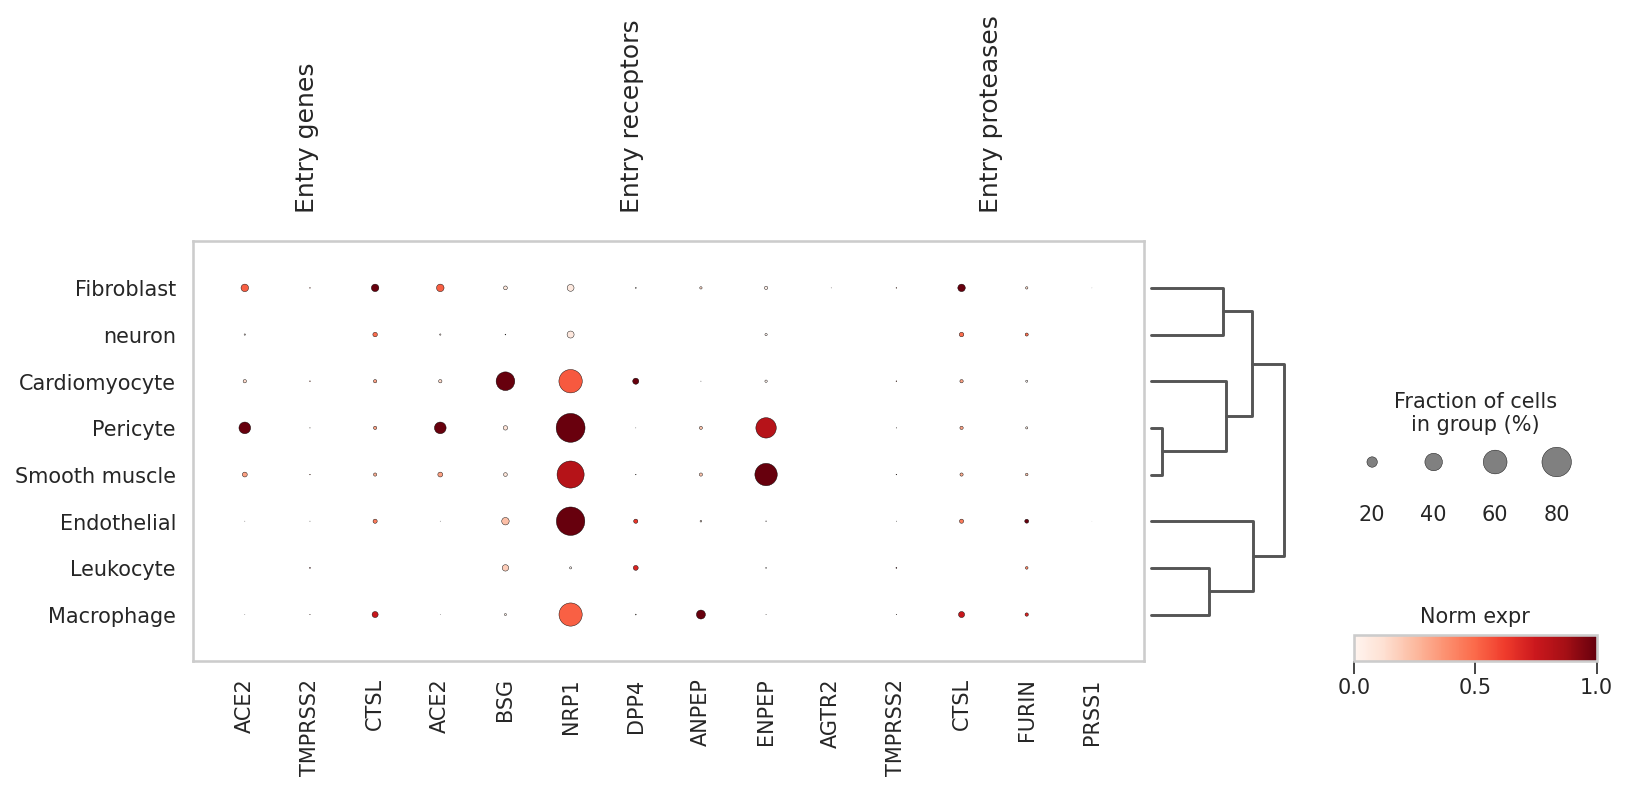

In [10]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12,5), gridspec_kw={'wspace':0.9})
sc.tl.dendrogram(adata, use_rep = 'X_scVI', groupby = cell_type_label) 
sc.pl.dotplot(adata, 
              var_names= utils.get_covid_genes() ,
              layer='counts',
              groupby=cell_type_label,
              log=True,
              standard_scale='var',
              colorbar_title = 'Norm expr',
              dendrogram=True, ax = ax1,
              save= this_sample + '_dotplot_COVID_genes.pdf')

## Expression of cell type markers 

categories: Cardiomyocyte, Endothelial, Fibroblast, etc.
var_group_labels: endothelial, cardiac muscle, fibroblast, etc.


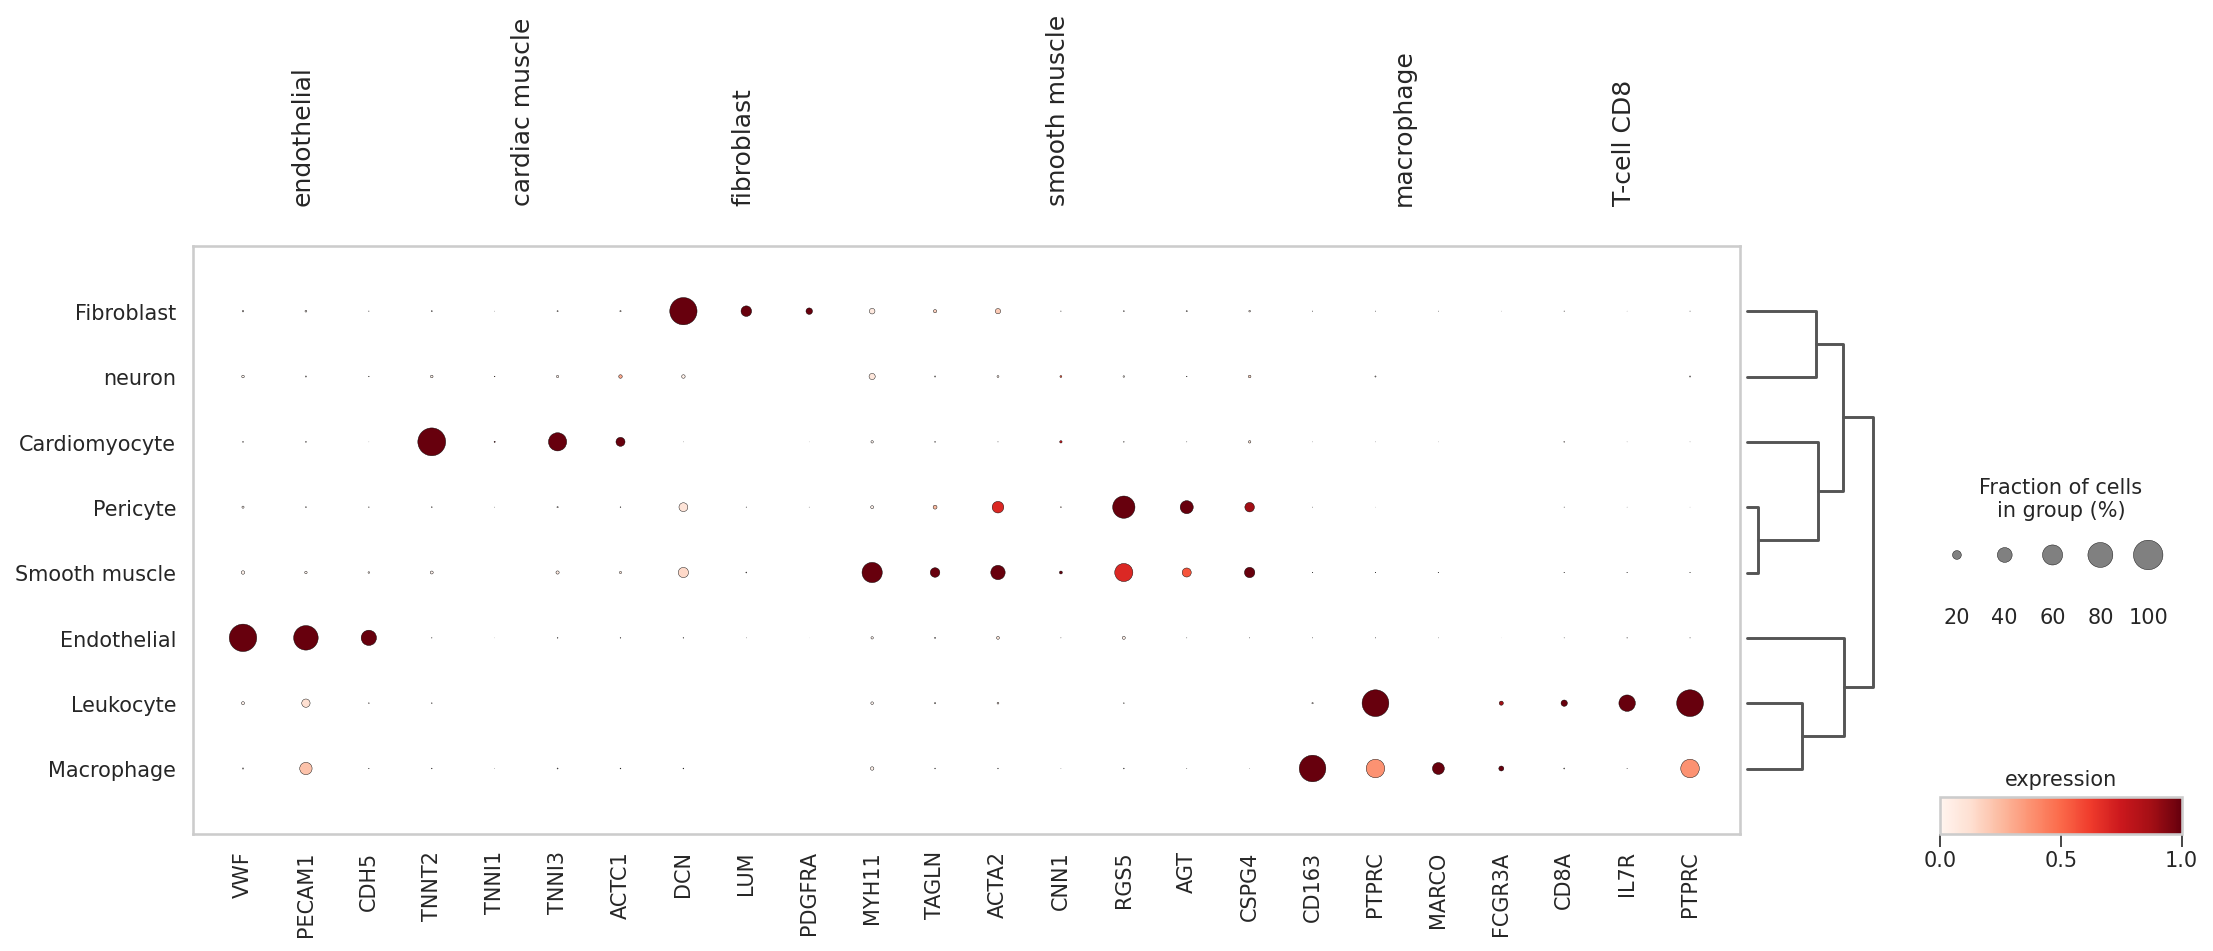

In [11]:
fig, (ax1) = plt.subplots(1, 1, figsize=(17,7), gridspec_kw={'wspace':0.9})

sc.pl.dotplot(adata, 
              var_names= utils.get_markers(this_sample),
              layer='counts',
              groupby= cell_type_label,
              log=True,
              standard_scale='var',
              colorbar_title = 'expression',
              dendrogram=True, ax = ax1,
              save= this_sample + '_dotplot_celltype_markers.pdf')

# R part 
Results from differential gene expression analysis in R. <br>
Results from pathway enrichment analysis <br> 
Results from CellPhone DB analysis. 

## Differential gene expression 
DE has been calculated using MAST (zero-inflated model with number of detected genes per cell as covariate) 

In [12]:
DGE_FILE = '/mnt/ibm_lg/covid_tissue_atlas/results/DGE/MAST/all_celltypes_DGE_ngenescovar_Nov_MAST.csv'

In [13]:
import rpy2
from rpy2.robjects import pandas2ri


%load_ext rpy2.ipython

pandas2ri.activate()

In [14]:
%Rpush this_sample
%Rpush FIG_DIR

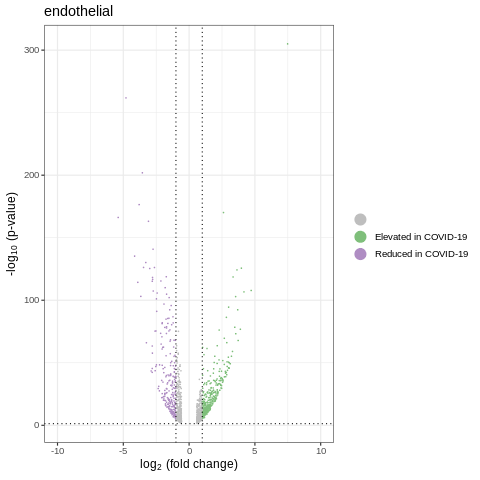

In [27]:
%%R
library(dplyr)
library(ggplot2)
library(ggsci)
library(viridis)

source('/mnt/ibm_lg/covid_tissue_atlas/CovidTissueAtlas/cta_utils/viz_utils.R')



# Read DGE results from MAST
DGE_FILE = '/mnt/ibm_lg/covid_tissue_atlas/results/DGE/MAST/all_celltypes_DGE_ngenescovar_Nov_MAST.csv'
dge_df = read.csv(DGE_FILE)

# In heart, remove neurons from final figure 
dge_df <- dge_df %>% dplyr::filter(cell_type !='neurons')

# Filter tissue and cell type of interest 
dge_df %>% filter(tissue == this_sample & cell_type =='endothelial') -> cell_type_df
cell_type_df %>% dplyr::filter(pval>0) -> cell_type_df

options(repr.plot.width=10, repr.plot.height=10)

volcano_plot(cell_type_df)

#ggsave(filename = paste0(FIG_DIR , this_sample, 'DGE_test.pdf'), width = 4, height = 2.5, dpi = 300)

Number of DE per cell type grouped by change direction

In [29]:
%%R -h 200 -w 300

tissue_df <- dge_df %>% dplyr::filter(tissue==this_sample) %>% dplyr::filter(abs(log2fc)>2 & pval <1e-3) 


plot_DE_direction(tissue_df, which_tissue =this_sample, log_x = FALSE)

ggsave(filename = paste0(FIG_DIR , this_sample, 'DGE_cell_type_rank.pdf'), width = 5.5, height = 2.5, dpi = 300)

`summarise()` has grouped output by 'tissue'. You can override using the `.groups` argument.


In [64]:
%%R -h 1200 -w 300
library(pheatmap)
library(tidyr)
library(RColorBrewer)

dge_df %>% mutate(expr = ifelse(log2fc >0, 'up','down')) %>% dplyr::filter(tissue ==this_sample) %>% 
        group_by(tissue, cell_type)  -> split_expression

split_expression %>% dplyr::filter(!grepl(pattern ='^MT', gene)) %>% group_by(cell_type, expr) %>% top_n(n =10, wt = abs(log2fc)) %>% 
        pivot_wider(id_cols = 'cell_type',names_from = 'gene', values_from = 'log2fc', values_fill = 0) -> log2_matrix 
    
cell_types <- log2_matrix$cell_type
log2_matrix <- log2_matrix[-1] %>% as.matrix()
row.names(log2_matrix) <- cell_types
options(repr.plot.width=20, repr.plot.height=6)

# clip values so that color palette is centered
min_val <- min(log2_matrix)
max_val <- max(log2_matrix)

clip_val <- min(max_val, abs(min_val))

log2_matrix[log2_matrix< -clip_val] <- -clip_val
log2_matrix[log2_matrix> clip_val] <- clip_val 

pheatmap(t(log2_matrix), clustering_method = 'ward.D2', clustering_distance_rows = 'correlation',
        height = 20, width = 5, filename = paste0(FIG_DIR , this_sample, 'DGE_heatmap.pdf'), 
        colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))(100),
        treeheight_row  = 0, treeheight_col  = 0,
         fontsize = 10)

In [65]:
%%R 

split_expression %>% group_by(cell_type, expr) %>% top_n(n =10, wt = abs(log2fc)) %>% 
        pivot_wider(id_cols = 'cell_type',names_from = 'gene', values_from = 'log2fc', values_fill = 0) -> log2_matrix 

log2_matrix[,c('cell_type','HSPD1')]

R[write to console]: Error: Can't subset columns that don't exist.
✖ Column `HSPD1` doesn't exist.
Run `rlang::last_error()` to see where the error occurred.




Error: Can't subset columns that don't exist.
✖ Column `HSPD1` doesn't exist.
Run `rlang::last_error()` to see where the error occurred.


## Expression of COVID genes 

In [11]:
# covid entry factors 
covid_entry_genes = ['ACE2', 'TMPRSS2', 'CTSL']
covid_entry_receptors = ['ACE2', 'BSG', 'NRP1', 'DPP4', 'ANPEP', 'ENPEP', 'AGTR2']
covid_entry_proteases = ['TMPRSS2', 'CTSL', 'FURIN', 'PRSS1']

## Cellphone DB
Nov 8th <br>
We are using cellphone db to estimate significant interactions between receptors and ligands across cell types. They require h5ad matrix + meta.data file with all the cell types. <br>
We are going to use 2 conditions per cell types by creating a full_celltype: entothelial_COVID 

In [ ]:
%%R
# CELLPhone DB plotting function. 
# Modified -- we don't use it 

library(ggplot2)
library(viridis)
dot_plot = function(selected_rows_path = NULL,
                    selected_columns_path = NULL,
                    filename = 'plot.pdf',
                    width = 8,
                    height = 10,
                    means_path = './means.txt',
                    pvalues_path = './pvalues.txt',
                    means_separator = '\t',
                    pvalues_separator = '\t',
                    output_extension = '.pdf'
){

  all_pval = read.table(pvalues_path, header=T, stringsAsFactors = F, sep=means_separator, comment.char = '', check.names=F)
  all_means = read.table(means_path, header=T, stringsAsFactors = F, sep=pvalues_separator, comment.char = '', check.names=F)

  # Control 
  selected_rows = read.table(selected_rows_path, sep = "\t", header = F)$V1
  selected_columns = read.table(selected_columns_path, sep = "\t", header = F)$V1  
    
  intr_pairs = all_pval$interacting_pair
  all_pval = all_pval[,-c(1:11)]
  all_means = all_means[,-c(1:11)]

  if(is.null(selected_rows)){
    selected_rows = intr_pairs
  }

  if(is.null(selected_columns)){
    selected_columns = colnames(all_pval)
  }

  sel_pval = all_pval[match(selected_rows, intr_pairs), selected_columns]
  sel_means = all_means[match(selected_rows, intr_pairs), selected_columns]

  df_names = expand.grid(selected_rows, selected_columns)
  pval = unlist(sel_pval)
  pval[pval==0] = 0.0009
  plot.data = cbind(df_names,pval)
  pr = unlist(as.data.frame(sel_means))
  pr[pr==0] = 1
  plot.data = cbind(plot.data,log2(pr))
  colnames(plot.data) = c('pair', 'clusters', 'pvalue', 'mean')

  my_palette <- colorRampPalette(c("black", "blue", "yellow", "red"), alpha=TRUE)(n=399)
  my_palette <- colorRampPalette(viridis(3), alpha=TRUE)(n=399)

  ggplot(plot.data,aes(x=clusters,y=pair)) +
  geom_point(aes(size=-log10(pvalue),color=mean)) +
  scale_color_gradientn('Log2 mean (Molecule 1, Molecule 2)', colors=my_palette) +
  theme_bw() +
  theme(panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),
        axis.text=element_text(size=14, colour = "black"),
        axis.text.x = element_text(angle = 90, hjust = 1),
        axis.text.y = element_text(size=12, colour = "black"),
        axis.title=element_blank(),
        panel.border = element_rect(size = 0.7, linetype = "solid", colour = "black"))

#   if (output_extension == '.pdf') {
#       ggsave(filename, width = width, height = height, device = cairo_pdf, limitsize=F)
#   }
#   else {
#       ggsave(filename, width = width, height = height, limitsize=F)
#   }
    return(plot.data)
}


In [31]:
%%R 
#source("/mnt/ibm_lg/covid_tissue_atlas/CovidTissueAtlas/cta_utils/viz_utils.R")
# results directory 
OUT_DIR = '/mnt/ibm_lg/covid_tissue_atlas/notebooks/cellphone/'

1. Read the ligand-receptor interactions in the COVID samples 

In [32]:
%%R -h 1200 -w 700
# read the output from cellphone db 

#this_sample = 'liver'
condition = "Cov19"
cpdb_path = paste0(OUT_DIR, this_sample, "/out_", condition,"/")

df_cov <- dot_plot(selected_rows_path = paste0(cpdb_path, 'rows_direction1.txt' ), 
                    selected_columns_path = paste0(cpdb_path, 'columns_direction1.txt'), 
                    means_path = paste0(cpdb_path,"means.txt"),
                    pvalues_path = paste0(cpdb_path,"pvalues.txt") )
        

2. Read the interactions in healthy tissue 

In [33]:
%%R

condition = "Control"
cpdb_path = paste0(OUT_DIR, this_sample, "/out_", condition,"/")

df_control <- dot_plot(selected_rows_path = paste0(cpdb_path, 'rows_direction1.txt' ), 
                    selected_columns_path = paste0(cpdb_path, 'columns_direction1.txt'), 
                    means_path = paste0(cpdb_path,"means.txt"),
                    pvalues_path = paste0(cpdb_path,"pvalues.txt") )

3. Option 1: Here we ask which interactions (pairs) show up in the COVID samples but NOT in the healthy tissue, those we called them **enriched in COVID** This filter is strict as we filter pairs of molecules if they appear in ANY cell type

In [34]:
%%R 
df_cov %>% dplyr::filter(!pair %in% df_control$pair) -> df_enriched

Plot only interactions enriched in COVID sample -- Figure for main result 

In [ ]:
%%R -h 600 -w 500
# our own dotplot 
 my_palette <- colorRampPalette(viridis(3), alpha=TRUE)(n=399)

interactionDotPlot <- function(df = data.frame() ){
    ggplot(df,aes(x=clusters,y=pair)) +
    geom_point(aes(size=-log10(pvalue),color=mean)) +
    scale_color_gradientn('Log2 mean (gene 1, gene 2)', colors=my_palette) +
    theme_bw() +
    theme(panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),
        axis.text=element_text(size=10, colour = "black"),
        axis.text.x = element_text(angle = 90, hjust = 1),
        axis.text.y = element_text(size=10, colour = "black"),
        axis.title=element_blank(),
        panel.border = element_rect(size = 0.7, linetype = "solid", colour = "black"))
    
}

interactionDotPlot(df_enriched)


3. Alternative: For each cell type, look for the enriched interactions in COVID that don't show up in the healthy cell type (less restrictive) <br> **use this**

In [36]:
%%R -h 1600 -w 500

paired_cov <- split(df_cov, df_cov['clusters'])
paired_control <- split(df_control, df_control['clusters'])

for(pp in 1:length(paired_cov)){
    
    a <- as.matrix(paired_control[[pp]]['pair'])
    row.names(a) <- NULL

    control_pairs <- a[,1]
    
    paired_cov[[pp]] <- paired_cov[[pp]] %>% dplyr::filter(!pair %in% control_pairs)
    row.names(paired_cov[[pp]]) <- NULL
}

cov_filtered <- do.call(rbind, paired_cov)

Enriched COVID interactions <br>
Show only those enriched in COVID that don't appear in the control 

In [ ]:
%%R -h 600 -w 500

 my_palette <- colorRampPalette(viridis(3), alpha=TRUE)(n=399)

interactionDotPlot(cov_filtered)

#ggsave(filename = paste0(FIG_DIR , this_sample, 'CellPhoneDB_cov19.pdf'), width = 5, height = 8, dpi = 300)

# Pathway analysis using multiple databases

In [54]:
%%R 

SETS_DIR =  "/mnt/ibm_lg/covid_tissue_atlas/results/gene_sets/pathfindr/"

#this_sample = 'liver'
db_list <- c('Reactome', 'KEGG', 'BioCarta', 'GO-All')
direction = 'up'
gene_sets = list() 
for(d in db_list){ 
	load( paste0(SETS_DIR, this_sample, '/all_cell_types_',d, '_' ,direction, '.rda') ) 
  tissue_pathways$database = d
	gene_sets[[d]] = tissue_pathways
}

path_df  = do.call(rbind, gene_sets) 

path_df %>% dplyr::filter(highest_p <0.0001 ) %>% group_by(cell_type, database)  %>% 
	top_n(n = -5, wt = highest_p)  %>% 
	select(Term_Description, cell_type, Fold_Enrichment, highest_p, support, database) %>% 
	arrange(highest_p) -> ranked_paths 

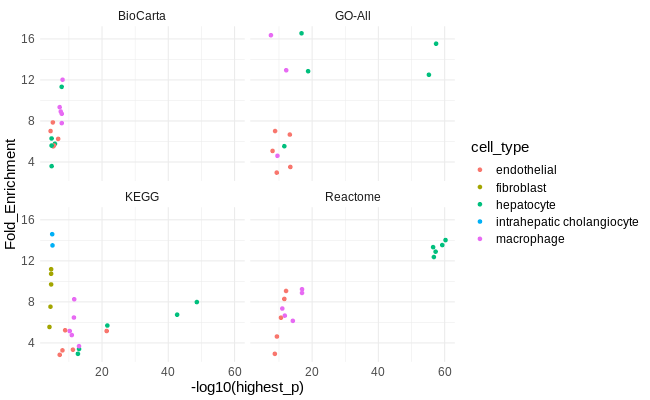

In [55]:
%%R -w 650 -h 400

ranked_paths %>% dplyr::filter(Fold_Enrichment <20)  %>% ggplot(aes(x = -log10(highest_p), y = Fold_Enrichment, color = cell_type)) + 
    geom_point() + theme_minimal() + theme(text =element_text(size =15)) +facet_wrap(~database)

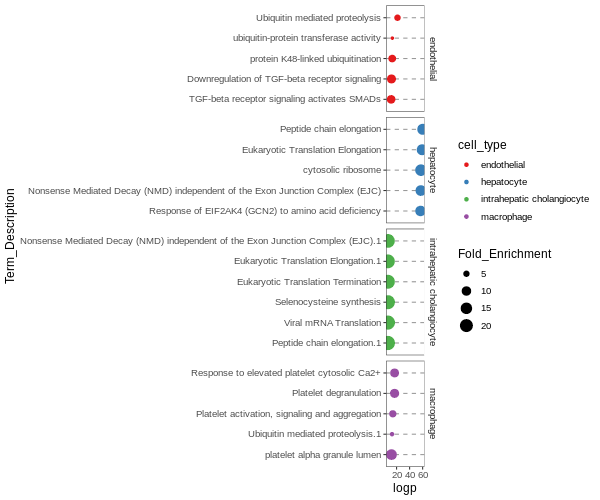

In [57]:
%%R -h 500 -w 600

#Rank top 5 regarding of database 
path_df %>% dplyr::filter(highest_p <0.000001 ) %>% group_by(cell_type)  %>% 
	top_n(n = -5, wt = highest_p)  %>% 
	select(Term_Description, cell_type, Fold_Enrichment, highest_p, support, database) %>% 
	arrange(highest_p) -> ranked_paths 
    
ranked_paths$logp <- -log10(ranked_paths$highest_p)

# Get the names, sorted first by lg, then by avg
ranked_paths$Term_Description <- make.unique(ranked_paths$Term_Description )
nameorder <- ranked_paths$Term_Description[order(ranked_paths$cell_type, ranked_paths$logp)]

# Turn name into a factor, with levels in the order of nameorder
ranked_paths$Term_Description <- factor(ranked_paths$Term_Description, levels = nameorder)

ranked_paths %>% ggplot(aes(x = logp, y = Term_Description)) + 
    scale_colour_brewer(palette = "Set1") + 
    geom_point(aes(colour = cell_type, size = Fold_Enrichment)) + theme_bw() + theme(text =element_text(size = 12)) + 
      theme(
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        panel.grid.major.y = element_line(colour = "grey60", linetype = "dashed")
      ) + 
        facet_grid(cell_type ~ ., scales = "free_y", space = "free_y") + 
        theme(strip.background =element_rect(fill="white",colour = "white"))
        
        
#ggsave(filename = paste0(FIG_DIR , this_sample, 'PathwaysUP_cov19.pdf'), width = 6.5, height = 3, dpi = 300)

### Save data.frame with top elements

In [100]:
%%R
export_df <- path_df %>% dplyr::filter(highest_p <0.000001) %>%  group_by(cell_type) %>% 
            top_n(n=-30, wt = highest_p)  %>% arrange(cell_type, highest_p)
write.table(export_df, file = paste0(SETS_DIR, this_sample,'/top_upTermsParsed.tsv' ),sep='\t',
           row.names = F)

# Appendix

### Export all tables 

In [97]:
%%R 

SETS_DIR =  "/mnt/ibm_lg/covid_tissue_atlas/results/gene_sets/pathfindr/"

getSigGeneSets <- function(this_sample = 'liver',
                           db_list = c('Reactome', 'KEGG', 'BioCarta', 'GO-All'),
                           direction = 'up',n_top = 30 ){
                    
    gene_sets = list() 
    for(d in db_list){ 
        load( paste0(SETS_DIR, this_sample, '/all_cell_types_',d, '_' ,direction, '.rda') ) 
      tissue_pathways$database = d
        gene_sets[[d]] = tissue_pathways
    }

    path_df  = do.call(rbind, gene_sets) 

    path_df %>% dplyr::filter(highest_p <0.001 ) %>% group_by(cell_type, database)  %>% 
        top_n(n = -n_top, wt = highest_p)  %>% 
        select(Term_Description, cell_type, Fold_Enrichment, highest_p, support, database, Up_regulated) %>% 
        arrange(highest_p) %>% rename( significant_genes = Up_regulated) -> ranked_paths 
    
    ranked_paths$direction = direction
    
    return(ranked_paths)
}

In [127]:
%%R 
EXPORT_DIR = '/mnt/ibm_lg/covid_tissue_atlas/results/gene_sets/pathfindr/export_data/'

for(t in c('liver','heart','lung','kidney')){
    this_sample = t
    ranked_paths_up <- getSigGeneSets(this_sample = t, direction ='up')
    ranked_paths_down <- getSigGeneSets(this_sample = t, direction ='down')

    all_sets <- rbind(ranked_paths_up, ranked_paths_down)



    export_list = split(all_sets , all_sets$cell_type) 

    for(c in names(export_list)){
        file_name <- str_replace(c, " ","_")
        x <- as.data.frame(export_list[c])
        colnames(x) <- colnames(all_sets)
        write.table(x, file = paste0(EXPORT_DIR, t,'/gene_sets_',file_name,'.tsv' ), sep = '\t', quote = F, row.names = F) 
    }
    
}

In [209]:
%%R 
DGE_DIR = '/mnt/ibm_lg/covid_tissue_atlas/results/DGE/MAST/'
EXPORT_DIR = '/mnt/ibm_lg/covid_tissue_atlas/results/gene_sets/pathfindr/export_data/'

# 1. Sort by up /down regulation 
# 2. Filter log2fc > abs(1)
# 3. Arrange into a spreadsheet where each cell type is saved into a different sheet 
# 4. Write a single Excel file for each organ 

# new File Dec 3 2021
dge_file = 'all_celltypes_DGE_ngenescovar_Nov_MAST.csv'
out_path = '/mnt/ibm_lg/covid_tissue_atlas/results/gene_sets/pathfindr/export_data/'
# if exported from python is has row.names as first column 
master_df <- read.csv(file = paste0(DGE_DIR, dge_file))
tissue_list <- unique(master_df$tissue)
for(t in tissue_list){
    tissue_df <- master_df[master_df$tissue== t,]
    cell_types <- tissue_df$cell_type %>% unique 
    
    # create xlsx file for each tissue 
    work_book <- createWorkbook()
    for(c in cell_types){
        file_name <- str_replace(c, " ","_")
        file_name <- str_replace(file_name, "/","_")
        
        cell_type_df <- tissue_df[tissue_df$cell_type==c, ]
        cell_type_df <- cell_type_df %>% mutate(direction = ifelse(log2fc >0, 'up','down'))
        cell_type_df <- cell_type_df %>% dplyr::filter(log2fc > abs(1))
        cell_type_df <- cell_type_df %>% arrange(desc(direction), pval)
        # add a sheet to the xlsx 
        addWorksheet(work_book, sheetName= str_trunc(c, 20, "right"))
        writeData(work_book, str_trunc(c, 20, "right"),cell_type_df )
        #write.table(cell_type_df, file = paste0(EXPORT_DIR, t,'/DGE_',file_name,'.tsv' ), sep = '\t', quote = F, row.names = F) 
    }
    # save xlsx
    saveWorkbook(work_book,
             file= paste0(out_path, "spreadsheets/", t, "_DE_all.xlsx"),
             overwrite = TRUE)
}

In [208]:
%%R 
tissue_list

[1] "liver"    "lung"     "kidney"   "prostate" "heart"   


In [129]:
%%R

master_df %>% head() 

   gene         pval     log2fc  cell_type tissue method covariate
1  A1CF 5.382071e-38 -1.4770036 hepatocyte  liver   MAST    ngenes
2   A2M 0.000000e+00  5.1522923 hepatocyte  liver   MAST    ngenes
3 AADAC 1.949123e-32 -0.8708030 hepatocyte  liver   MAST    ngenes
4  AARS 2.468486e-20  0.6774417 hepatocyte  liver   MAST    ngenes
5  AASS 2.874990e-64 -2.1035995 hepatocyte  liver   MAST    ngenes
6  ABAT 1.574661e-20 -1.0831059 hepatocyte  liver   MAST    ngenes


Export Excel files -- preferred method

In [198]:
%%R 
# adapted from shared responess. 
# here we export one file per organ. 
#  databases are split into separate sheets
#  pathways are sorted first by cell type and then by p-value 
exportResults <- function(this_sample = 'liver',
                         direction ='up' ,
                         db_list = c('Reactome', 'KEGG', 'BioCarta', 'GO-All') ,
                         
                         min_pval = 0.01,
                         out_path = '/mnt/ibm_lg/covid_tissue_atlas/results/gene_sets/pathfindr/export_data/'
                         ){
    work_book <- createWorkbook()
    
        
 
    for(d in db_list){ 
      load( paste0(SETS_DIR, this_sample, '/all_cell_types_',d, '_' ,direction, '.rda') )  
      tissue_pathways$database = d
      tissue_pathways <- tissue_pathways %>% dplyr::filter(highest_p < min_pval)
      tissue_pathways <- tissue_pathways %>% dplyr::filter(highest_p < min_pval)
      tissue_pathways <- tissue_pathways %>% group_by(cell_type) %>% arrange(cell_type, highest_p)  
        
      if(direction =="up"){
          n_genes_used <- apply(!str_split(tissue_pathways$Up_regulated, ",", simplify = T) =="", 1, sum)
      }else if(direction =="down"){
          n_genes_used <- apply(!str_split(tissue_pathways$Down_regulated, ",", simplify = T) =="", 1, sum)
      }
      #consider only pathways with more than one gene used in the enrichment 
      tissue_pathways$n_genes_used <- n_genes_used 
      tissue_pathways <- tissue_pathways %>% dplyr::filter(n_genes_used >1 )
      tissue_pathways <- tissue_pathways %>% dplyr::filter(occurrence >1 )

      #tissue_pathways <- tissue_pathways %>% select(-c())
        # save to Excel 
        addWorksheet(work_book, sheetName= d)
        writeData(work_book, d,tissue_pathways )
    }

    saveWorkbook(work_book,
             file= paste0(out_path, "spreadsheets/", this_sample, "_genesets_",direction,"regulated.xlsx"),
             overwrite = TRUE)

}

In [199]:
%%R 
library(tidyverse)
library(openxlsx)

for(cc in c('liver', 'lung','heart','kidney'))
    exportResults(this_sample =cc, direction = "up")

In [201]:
%%R 
for(cc in c('liver', 'lung','heart','kidney'))
    exportResults(this_sample =cc, direction = "down")

# Review final objects

In [8]:

tissue = 'prostate'
file_name = tissue + '_CTA_only.h5ad'
adata = sc.read_h5ad('/mnt/ibm_lg/covid_tissue_atlas/data/tissue_objects/all_tissues/' + tissue + "/" + file_name)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


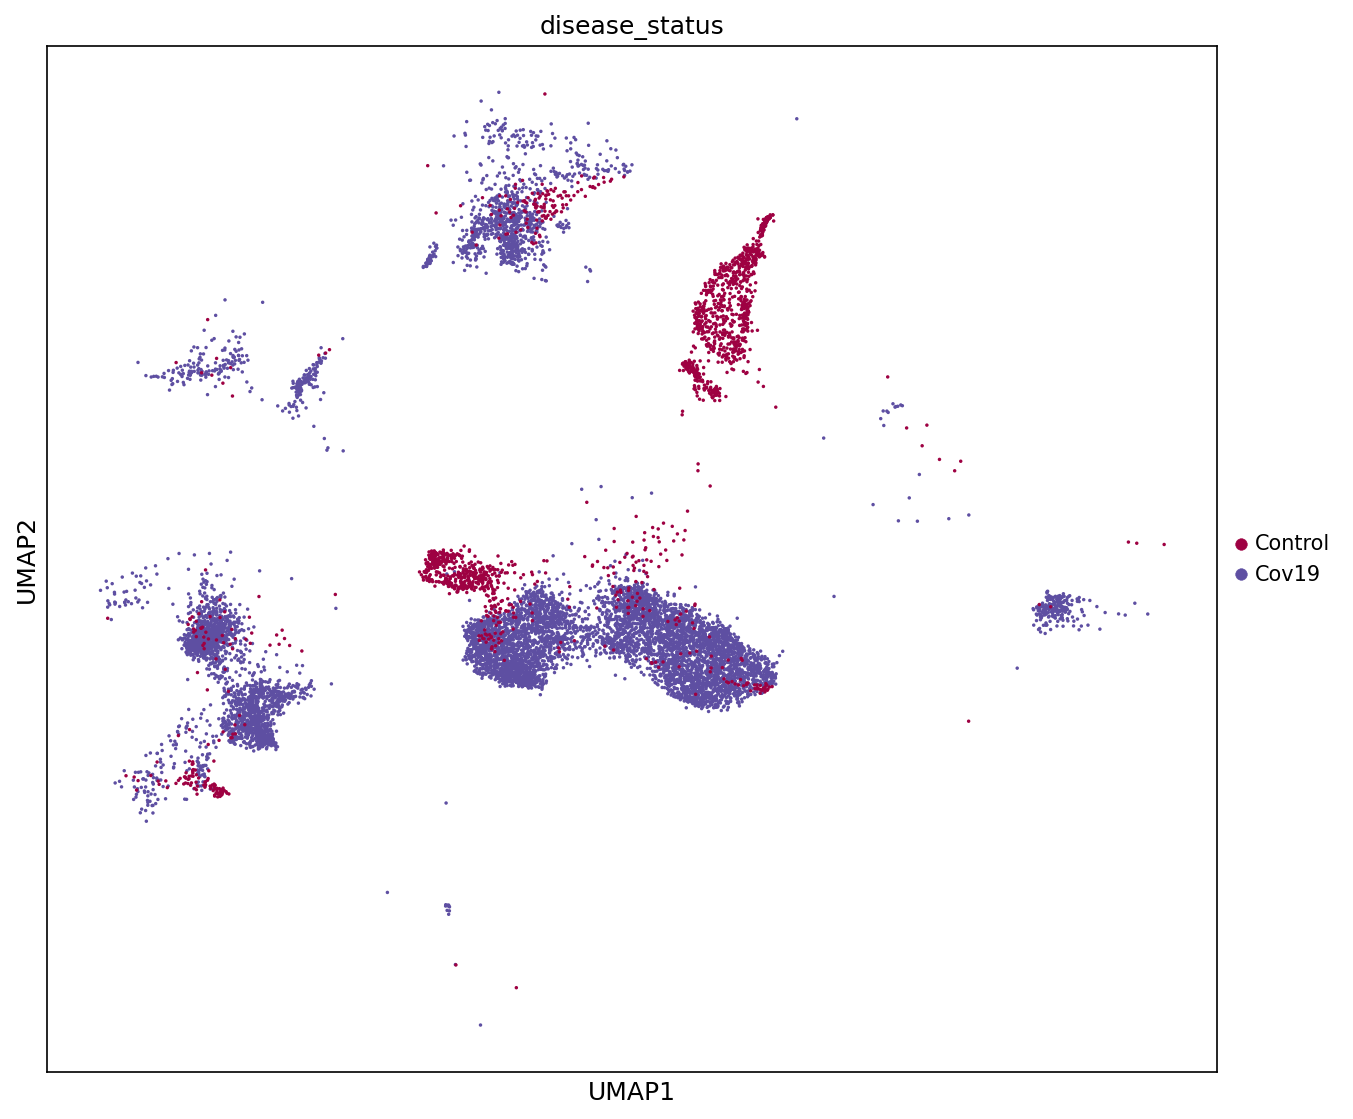

In [9]:
sc.pl.umap(adata, color  ='disease_status')

In [10]:
adata.obs.head() 

,cell_type_annotation,sample_origin,10X_run,leiden,disease_status,tissue,batch,race,age,source,sex,test_positive_hrs_before_death,cell_class,cell_ontology_class
index,,,,,,,,,,,,,,
1-5GGTTAACGTTATTCTC-1,basal epithelial,UCSF-1-5_prostate,UCSF-1-5,14,Cov19,prostate,0,African Am,70,UCSF,M,552.0,basal,basal cell
1-5CTATCCGTCGACTCCT-1,smooth muscle,UCSF-1-5_prostate,UCSF-1-5,22,Cov19,prostate,0,African Am,70,UCSF,M,552.0,smooth muscle,smooth muscle cell of prostate
1-5CGATGGCGTATACAGA-1,basal epithelial,UCSF-1-5_prostate,UCSF-1-5,14,Cov19,prostate,0,African Am,70,UCSF,M,552.0,basal,basal cell
1-5AAAGGATAGTCTTCGA-1,basal epithelial,UCSF-1-5_prostate,UCSF-1-5,14,Cov19,prostate,0,African Am,70,UCSF,M,552.0,basal,basal cell
1-5TACTTACCACAGTCGC-1,basal epithelial,UCSF-1-5_prostate,UCSF-1-5,14,Cov19,prostate,0,African Am,70,UCSF,M,552.0,basal,basal cell


In [11]:
set(adata.obs['cell_ontology_class'])

{'Sertoli cell',
 'basal cell',
 'endothelial cell',
 'epithelial cell',
 'fibroblast',
 'hillock cell',
 'luminal cell of prostate epithelium',
 'myeloid cell',
 'smooth muscle cell of prostate',
 'striated muscle cell',
 't cell'}

In [8]:
set(adata.obs['cell_type_annotation'])

{'endothelial',
 'fibroblast',
 'hepatocyte',
 'intrahepatic cholangiocyte',
 'macrophage',
 'natural killer cell'}

In [22]:
utils.short_celltype_names('lung')

{'type i pneumocyte': 'AT-I',
 'type ii pneumocyte': 'AT-II',
 'lung ciliated cell': 'Ciliated',
 't cell': 'T-cell',
 'lung macrophage': 'Macrophage',
 'lung endothelial cell': 'Endothelial',
 'fibroblast of lung': 'Fibroblast',
 'dendritic cell': 'Dendritic',
 'basal cell': 'Basal',
 'b cell': 'B cell'}

In [6]:
file_name = 'CTA_all.h5ad'
adata = sc.read_h5ad('/mnt/ibm_lg/covid_tissue_atlas/data/tissue_objects/all_tissues/portal/' + file_name)

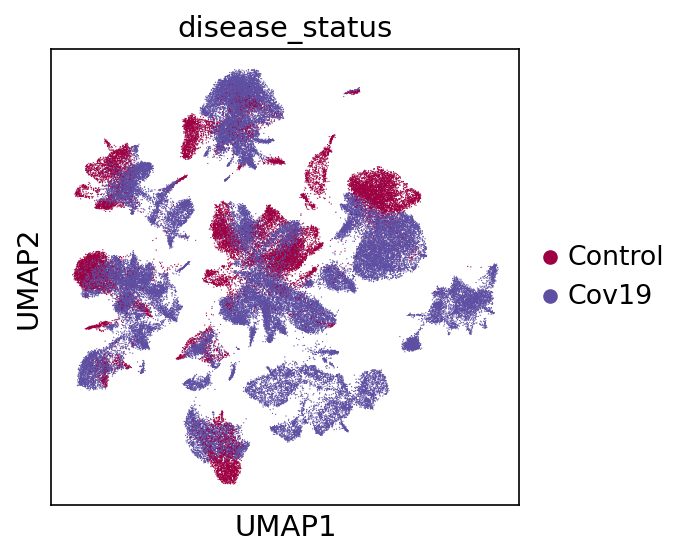

In [7]:
sc.pl.umap(adata, color = 'disease_status')

In [12]:
adata.obs.head() 

,cell_type_annotation,sampleID,donorID,leiden,disease_status,tissue,race,age,source,sex,test_positive_hrs_before_death,cell_class,cell_ontology_class
index,,,,,,,,,,,,,
S02_CAACAACAGGAACGTC-1,epithelial cell of proximal tubule,S02_kidney,S02,20,Cov19,kidney,White,74,Saarland,F,24.0,epithelial,epithelial cell of proximal tubule
S02_CACTGAACACTGGACC-1,epithelial cell of proximal tubule,S02_kidney,S02,20,Cov19,kidney,White,74,Saarland,F,24.0,epithelial,epithelial cell of proximal tubule
S02_TTCCTTCCAAACCATC-1,renal principal cell,S02_kidney,S02,17,Cov19,kidney,White,74,Saarland,F,24.0,epithelial,renal principal cell
S02_CTCCATGGTTGGTGTT-1,kidney loop of henle thick ascending limb epit...,S02_kidney,S02,17,Cov19,kidney,White,74,Saarland,F,24.0,epithelial,kidney loop of henle thick ascending limb epit...
S02_CTACATTAGCCTATCA-1,renal principal cell,S02_kidney,S02,17,Cov19,kidney,White,74,Saarland,F,24.0,epithelial,renal principal cell
